# 6. Tree-based methods

The first step is to activate the packages and load the data.

In [1]:
import pyreadr
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime as dt
from sklearn.linear_model import LinearRegression 
import seaborn as sns
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
np.random.seed(0)

In [3]:
#data_ml = pyreadr.read_r(insert path of data_ml.RData)["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)

data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)

We also copy/paste some chunks from Chapter 2.


In [4]:
stock_ids = data_ml.stock_id.unique() 
stock_days = data_ml.stock_id.value_counts().sort_index() 
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]

returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index=['date'],columns='stock_id',values='R1M_Usd')  
features = list(data_ml.columns[2:95]) 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')
data_ml['R12M_Usd_C'] = data_ml.R12M_Usd >  data_ml.groupby('date').R12M_Usd.transform('median')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

The order of above operations matters: we need the categorical variables like R1M_Usd_C to be present in the training & testing samples.

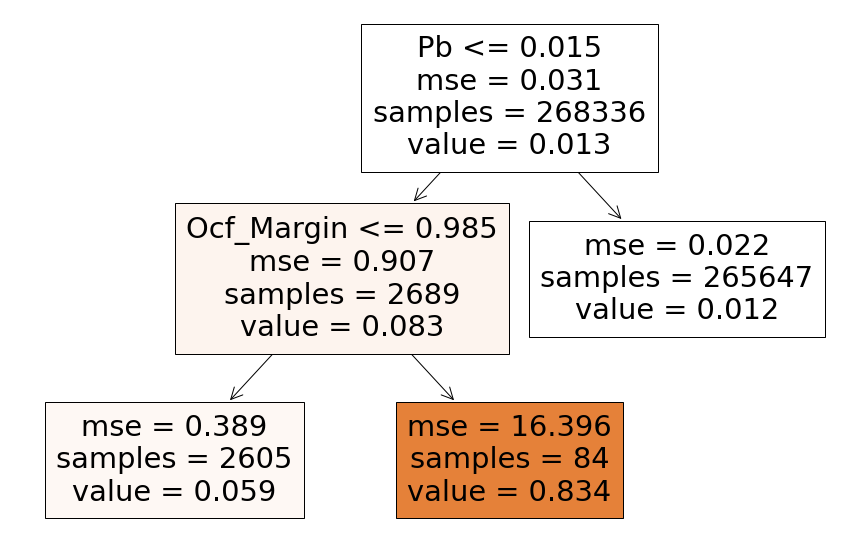

In [5]:
fit_tree = DecisionTreeRegressor(min_samples_leaf = 35, #The minimum number of samples required to be at a leaf node.change variable 3500 to 35 
                                min_samples_split = 800,#The minimum number of samples required to split an internal node. change variable 8000 to 800 
                                ccp_alpha = 0.0001,     #Complexity parameter used for Minimal Cost-Complexity Pruning. smaller cp = more leaves
                                max_depth = 3)          #The maximum depth of the tree
fit_tree.fit(data_ml[features], data_ml.R1M_Usd)
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(fit_tree, 
                   feature_names=features,  
                   class_names=data_ml.R1M_Usd,
                   filled=True)

Then: related predictions.


In [6]:
fit_tree.predict(data_ml[features][:6])

array([0.0120192, 0.0120192, 0.0120192, 0.0120192, 0.0120192, 0.0120192])

As a verification of the first splits, we plot the smoothed average of future returns, conditionally on market capitalization, past return and trading volume.


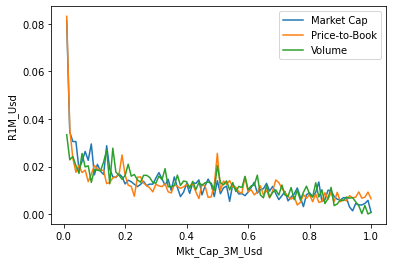

In [7]:
sns.lineplot(data=data_ml,x="Mkt_Cap_3M_Usd", y="R1M_Usd", ci=None)
sns.lineplot(data=data_ml,x="Pb", y="R1M_Usd", ci=None)
sns.lineplot(data=data_ml,x="Advt_3M_Usd", y="R1M_Usd", ci=None)
plt.legend(labels=['Market Cap', 'Price-to-Book','Volume'])

Finally, we assess the predictive quality of a single tree on the testing set (the tree is grown on the training set). We use a deeper tree, with a maximum depth of five.


In [8]:
fit_tree2 = DecisionTreeRegressor(min_samples_leaf = 15, #The minimum number of samples required to be at a leaf node.change variable 1500 to 15
                                min_samples_split = 400, #The minimum number of samples required to split an internal node.change variable 4000 to 400
                                ccp_alpha = 0.0001,      #Complexity parameter used for Minimal Cost-Complexity Pruning. smaller cp = more leaves
                                max_depth = 5)           #The maximum depth of the tree
fit_tree2.fit(training_sample[features], training_sample.R1M_Usd)

DecisionTreeRegressor(ccp_alpha=0.0001, max_depth=5, min_samples_leaf=15,
                      min_samples_split=400)

In [9]:
print("MSE:", mean_squared_error(fit_tree2.predict(testing_sample[features]), testing_sample.R1M_Usd) )
print("Hit ratio:", (fit_tree2.predict(testing_sample[features]) * testing_sample.R1M_Usd > 0 ).mean() )


MSE: 0.03699695809185004
Hit ratio: 0.5460346399270738


Next, we turn to random forests.

The syntax of randomForest follows that of many ML libraries. The full list of options for some random forest implementations is prohibitively large.^[See, e.g., http://docs.h2o.ai/h2o/latest-stable/h2o-r/docs/reference/h2o.randomForest.html] Below, we train a model and exhibit the predictions for the first 5 instances of the testing sample.   

In [10]:
fit_RF = RandomForestRegressor( max_samples = 10000,    #If bootstrap is True, the number of samples to draw from X to train each base estimator.
                                bootstrap = False,     #Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
                                min_samples_leaf= 250,  #The minimum number of samples required to be at a leaf node. 
                                n_estimators = 40,      #The number of trees in the forest.
                                max_features = 30)      #The number of features to consider when looking for the best split:
                
fit_RF.fit(training_sample[features], training_sample.R1M_Usd)
fit_RF.predict(training_sample[features][:6])

array([0.03885208, 0.04339757, 0.03653777, 0.03772612, 0.02457307,
       0.02020467])

We can assess the accuracy of the model.


In [11]:
print("MSE:", mean_squared_error(fit_RF.predict(testing_sample[features]), testing_sample.R1M_Usd) )
print("Hit ratio:", (fit_RF.predict(testing_sample[features]) * testing_sample.R1M_Usd > 0 ).mean() )


MSE: 0.03686231645472145
Hit ratio: 0.5406933682771194


The MSE is smaller than 4% and the hit ratio is close to 54%, which is reasonably above both 50% and 52% thresholds.

Let's see if we can improve the hit ratio by resorting to a classification exercise. We start by training the model on a new formula (the label is R1M_Usd_C).

In [12]:
fit_RF_C = RandomForestClassifier( max_samples = 20000, #If bootstrap is True, the number of samples to draw from X to train each base estimator.
                                bootstrap = False,     #Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
                                min_samples_leaf= 250,  #The minimum number of samples required to be at a leaf node. 
                                n_estimators = 40,      #The number of trees in the forest.
                                max_features = 30)      #The number of features to consider when looking for the best split:
fit_RF_C.fit(training_sample[features], training_sample.R1M_Usd_C)

RandomForestClassifier(bootstrap=False, max_features=30, max_samples=20000,
                       min_samples_leaf=250, n_estimators=40)

We can then assess the proportion of correct (binary) guesses.


In [13]:
print("Hit ratio:", (fit_RF_C.predict(testing_sample[features]) == testing_sample.R1M_Usd_C ).mean() )

Hit ratio: 0.5028059480401094


The accuracy is disappointing. 

Below, move to the original adaboost classifier. As such, we work with the R1M_Usd_C variable and change the model formula. The computational cost of adaboost is high on large datasets, thus we work with a smaller sample and we only impose three iterations.


In [14]:
subsample = np.arange( int(len(training_sample)/4))*4
training_sub_sample= training_sample.iloc[subsample]
fit_adaboost_C = AdaBoostClassifier(n_estimators=100)  #The maximum number of estimators at which boosting is terminated.
fit_adaboost_C.fit(training_sub_sample[features], training_sub_sample.R1M_Usd_C)

AdaBoostClassifier(n_estimators=100)

Finally, we evaluate the performance of the classifier.


In [15]:
print("Hit ratio:", (fit_adaboost_C.predict(testing_sample[features]) == testing_sample.R1M_Usd_C ).mean() )

Hit ratio: 0.5020937784867822


Next, we move to boosted trees.

In this section, we train a model using the *XGBoost* library. Other options include *catboost*, *gbm*, *lightgbm*, and *h2o*'s own version of boosted machines. Unlike many other packages, the XGBoost function requires a particular syntax and dedicated formats. The first step is thus to encapsulate the data accordingly.

Moreover, because training times can be long, we shorten the training sample: we retain only the 40% most extreme observations (in terms of label values: top 20% and bottom 20%) and work with the small subset of features. 


In [16]:
top20 = training_sample.R1M_Usd.quantile(0.8) 
bottom20= training_sample.R1M_Usd.quantile(0.2)
train_features = training_sample[training_sample.R1M_Usd>top20]
train_features = train_features.append(training_sample[training_sample.R1M_Usd<bottom20])
train_features = train_features.sort_values(by=['stock_id','date'])
train_features_xgb = train_features[features_short]
train_label_xgb = train_features.R1M_Usd

The second (optional) step is to determine the monotonicity constraints that we want to impose. For simplicity, we will only enforce three constraints on    

1. market capitalization (negative, because large firms have smaller returns under the size anomaly);   
2. price-to-book ratio (negative, because overvalued firms also have smaller returns under the value anomaly);   
3. past annual returns (positive, because winners outperform losers under the momentum anomaly).  

In [17]:
mono_const = np.zeros(len(features))
mono_const += (np.array(features)=='Mkt_Cap_12M_Usd' ) * -1
mono_const += (np.array(features)=='Pb' ) * -1
mono_const += (np.array(features)=='Mom_11M_Usd' ) * 1

The third step is to train the model on the formatted training data. 


In [18]:
fit_xgb = xgb.XGBRegressor(     
              learning_rate  = 0.3,                                                        #Boosting learning rate                 
              objective = "reg:linear",                                                    #Specify the learning task and the corresponding learning objective or a custom objective function to be used      
              max_depth = 4,                                                               #Maximum tree depth for base learners.
              reg_lambda = 1,                                                              #L2 regularization term on weights
              gamma = 0.1,                                                                 #Minimum loss reduction required to make a further partition on a leaf node of the tree.
              n_estimators = 30,                                                           #Number of trees in random forest to fit.
              monotone_constraints = '('+','.join(str(int(x)) for x in mono_const) + ')', #Constraint of variable monotonicity. See tutorial for more information.
              verbosity  = 0)                                                              #The degree of verbosity
fit_xgb.fit(train_features_xgb,train_label_xgb )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=30, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

Finally, we evaluate the performance of the model. Note that before that, a proper formatting of the testing sample is required.


In [19]:
xgb_test = testing_sample[features_short]
print("MSE:", mean_squared_error(fit_xgb.predict(xgb_test), testing_sample.R1M_Usd) )
print("Hit ratio:", (fit_xgb.predict(xgb_test) * testing_sample.R1M_Usd > 0 ).mean() )

MSE: 0.0380439641348656
Hit ratio: 0.5047145624430265


The performance is comparable to those observed for other predictive tools. As a final exercise, we show one implementation of a classification task under XGBoost. Only the label changes. In XGBoost, labels must be coded with integer number, starting at zero exactly. When working with categories, the loss function is usually the softmax function.
 

In [20]:
train_label_C = train_features['R1M_Usd_C']
fit_xgb_C = xgb.XGBClassifier(     
              learning_rate  = 0.8,                      #Number of trees in random forest to fit.
              objective = "multi:softmax",               #Specify the learning task and the corresponding learning objective or a custom objective function to be used
              num_class = 2,                             #In the Sklearn XGB API you do not need to specify the num_class parameter explicitly. 
              max_depth = 4,                             #Maximum tree depth for base learners.                
              n_estimators = 10,                         #Number of trees in random forest to fit.
              verbosity  = 0)                            #The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
fit_xgb_C.fit(train_features_xgb,train_label_C )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.8, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_class=2, num_parallel_tree=1,
              objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

We can then proceed to the assessment of the quality of the model. We adjust the prediction to the value of the true label and count the proportion of accurate forecasts.


In [21]:
print("Hit ratio:", (fit_xgb_C.predict(testing_sample[features_short]) == testing_sample.R1M_Usd_C ).mean() )

Hit ratio: 0.4956130355515041
